# Two-level system tutorial

## Import

In [77]:
import numpy as np
from matplotlib import pyplot as plt
from qutip import*
from scipy.special import eval_hermite as hpoly
import sys
sys.path.append('/Users/longnguyen/Documents/GitHub/Fluxonium_berkeley/')
from Fluxonium_hamiltonians import Single_small_junction as fluxonium
import plotting_settings
import scipy.linalg

## States, Bloch sphere

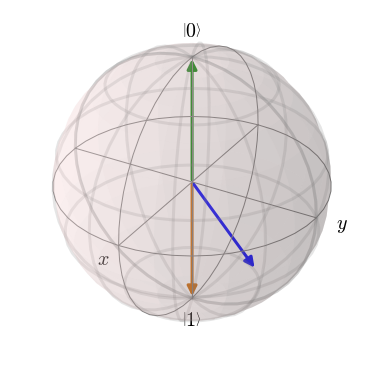

In [56]:
psi0 = basis(2,0)
psi1 = basis(2,1)
a=3
b=3j+2
psi = (a*psi0 + b*psi1)/np.sqrt(abs(a)**2+abs(b)**2)
b = Bloch()
b.add_states([psi0,psi1,psi])
b.make_sphere()

## State tomography

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.40909091+0.j         0.40909091-0.27272727j]
 [0.40909091+0.27272727j 0.59090909+0.j        ]]


<Figure size 504x504 with 0 Axes>

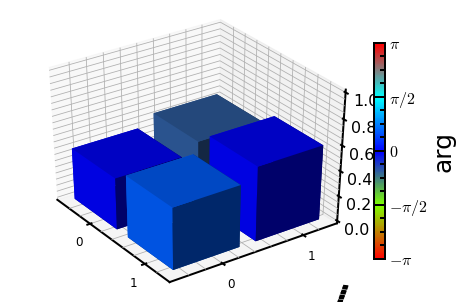

In [60]:
#State tomography
plt.figure(figsize=[7,7])
rho = ket2dm(psi)
matrix_histogram_complex(rho)
print (rho)

(<Figure size 432x288 with 2 Axes>,
 <mpl_toolkits.mplot3d.axes3d.Axes3D at 0x7f93e157bd00>)

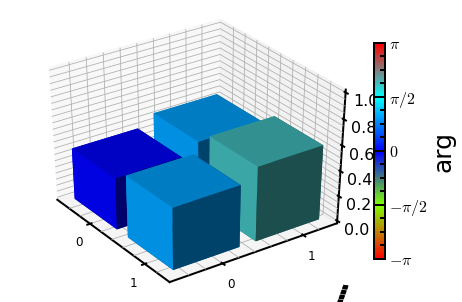

In [75]:
#Can also define matrices
psi0 = np.matrix([1,0]).transpose()
psi1 = np.matrix([0,1]).transpose()
a=3
b=3j+2
psi = (a*psi0 + b*psi1)/np.sqrt(abs(a)**2+abs(b)**2)
# psi = Qobj(psi)
# rho = ket2dm(psi)
#or
rho = psi*psi.transpose()
rho = Qobj(rho)
matrix_histogram_complex(rho)

## Quantum state fidelity

In [85]:
#Using qutip's fidelity function
psi0 = basis(2,0)
psi1 = basis(2,1)
a=3
b=3j+2
psi = (a*psi0 + b*psi1)/np.sqrt(abs(a)**2+abs(b)**2)
print (fidelity(psi0,psi1))
print (fidelity(psi1,psi1))
print (fidelity(psi1,psi))

#Or define it ourselves
rho0 = np.array([[1,0],[0,0]])
rho1 = np.array([[0,0],[0,1]])

def state_fidelity(rho,rho_ideal):
    f = abs(np.trace(scipy.linalg.sqrtm(scipy.linalg.sqrtm(rho_ideal).dot(rho).dot(scipy.linalg.sqrtm(rho_ideal)))))
    return f

print (state_fidelity(rho0,rho0))

0.0
1.0
0.7687061147858073
1.0


## Quantum state tomography

## Quantum process tomography

## Driving two-level system
Here, we define the two-level system via the Hamiltonian $$H=\frac{1}{2}\omega_a\sigma_Z$$ and the driving term 
$$H_d= g\cos(\omega_d t)\sigma_X$$

Text(0, 0.5, '$\\langle \\sigma_Z \\rangle$')

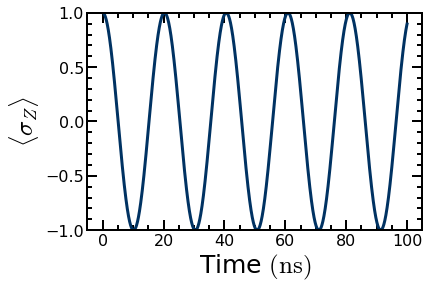

In [147]:
atom_freq = 5 #GHz
drive_freq = 5 #GHz
coupl_const = 0.05 #GHz
H0 = 2*np.pi*0.5*atom_freq*sigmaz()
H1 = 2*np.pi*coupl_const*sigmax()
    
# def H1_coeff(time,wd):
#     return np.cos(2*np.pi*wd*time)

tlist = np.linspace(0,100,2001)*1
H = [H0,[H1, np.cos(2*np.pi*drive_freq*tlist)]]
output = mesolve(H, rho0=basis(2,0), tlist=tlist, c_ops=[], e_ops=sigmaz())
sz = output.expect[0]
plt.plot(tlist, sz)
# U_t = propagator(H, tlist,[])
plt.ylim([-1,1])
plt.xlabel(r'Time $\mathrm{(ns)}$')
plt.ylabel(r'$\langle \sigma_Z \rangle$')

Text(0, 0.5, '$\\langle \\sigma_Z \\rangle$')

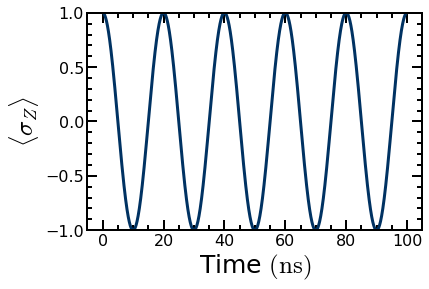

In [148]:
#Using RWA
H = 2*np.pi*0.5*(atom_freq-drive_freq)*sigmaz() + 2*np.pi*0.5*coupl_const*sigmax()
output = mesolve(H, rho0=basis(2,0),tlist = tlist, c_ops=[], e_ops=sigmaz())
sz = output.expect[0]
plt.plot(tlist,sz)
plt.ylim([-1,1])
plt.xlabel(r'Time $\mathrm{(ns)}$')
plt.ylabel(r'$\langle \sigma_Z \rangle$')

In [185]:
#Here we define a pulse that rotates the spin by 2pi
#Also define DRAG coefficient, which we will explore later
def H_gate_pulse(t, omega_d, DRAG, DRAG_coeff, shape, sigma, T_gate):
    """ 
    H_drive_coeff_gate = xi_x(t) cos(wt) + xi_y(t) sin(wt)
    Normalization: \int xi(t') dt'= 2\pi for 0 < t' < T_gate
    If DRAG == True: xi_y(t) = alpha * d xi_x / dt,
    else: xi_y = 0
    """ 
    two_pi_t = 2 * np.pi * t
    if DRAG:
        alpha = DRAG_coeff
    else:
        alpha = 0
    if shape == 'square':
        xi_x = 1 / T_gate
        xi_y = 0
    elif shape == 'gauss':
        sigma = sigma * T_gate
        integral_value = (np.sqrt(2 * np.pi) * sigma
                          * scipy.special.erf(
                    T_gate / (2 * np.sqrt(2) * sigma))
                          - T_gate * np.exp(-0.5 * (0.5 * T_gate / sigma) ** 2))
        coeff = 2 * np.pi / integral_value
        xi_x = coeff * (np.exp(- 0.5 * ((t - T_gate / 2) / sigma) ** 2)
                        - np.exp(-0.5 * (0.5 * T_gate / sigma) ** 2))
        xi_y = (alpha * coeff * (- (t - T_gate / 2) / sigma ** 2)
                * np.exp(- 0.5 * ((t - T_gate / 2) / sigma) ** 2))
    return (xi_x * np.cos(two_pi_t*omega_d)
            + xi_y * np.sin(two_pi_t*omega_d))

Text(0, 0.5, '$\\mathrm{P_0}$')

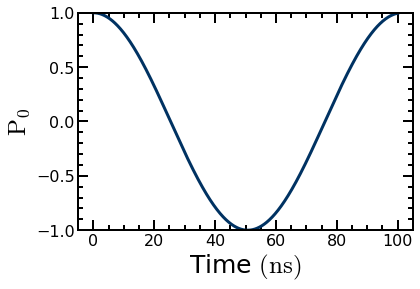

In [187]:
atom_freq = 5 #GHz
drive_freq = 5 #GHz
coupl_const = 1 #GHz
H0 = 2*np.pi*0.5*atom_freq*sigmaz()
H1 = 2*np.pi*coupl_const*sigmax()

tlist = np.linspace(0,100,2001) #ns
H = [H0,[H1, H_gate_pulse(tlist, omega_d = drive_freq, sigma = 0.25, T_gate = 100, DRAG = False, DRAG_coeff = 0, shape = "square")]]
output = mesolve(H, rho0=basis(2,0), tlist=tlist, c_ops=[], e_ops=sigmaz())
sz = output.expect[0]
plt.plot(tlist, sz)
# U_t = propagator(H, tlist,[])
plt.ylim([-1,1])
plt.xlabel(r'Time $\mathrm{(ns)}$')
plt.ylabel(r'$\mathrm{P_0}$')

In [198]:
output = mesolve(H, rho0=basis(2,0), tlist=tlist, c_ops=[], e_ops=[])
states = output.states

#Now we can check the fidelity of the state
print (fidelity(states[-1], basis(2,0)))

0.9989459517278001


In [196]:
#for now, we can also check the gate fidelity
U_t = propagator(H, t=tlist)
print(U_t[-1]*basis(2,0))
# U_ideal = qeye(2)
# print(fidelity(U_t[-1],U_ideal))

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-9.98944259e-01+2.90841584e-06j]
 [-3.51380916e-06-4.59387427e-02j]]
